In [19]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from workalendar.usa import Illinois
import geopandas as gpd
from shapely.wkt import loads
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape

RAW_DATA_DIR = "../../data/raw data"
PROCESSED_DATA_DIR = "../../data/processed data"

In [20]:
cta = pd.read_csv(os.path.join(RAW_DATA_DIR, "chicago_cta_bus.csv"))
cta_geo = pd.read_csv(os.path.join(RAW_DATA_DIR, "chicago_cta_bus_routes.csv"))

/var/folders/_x/43n5hx2d6hqf1v6v65qbln8c0000gn/T/ipykernel_65067/2574165383.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cta = pd.read_csv(os.path.join(RAW_DATA_DIR, "chicago_cta_bus.csv"))


<Axes: >

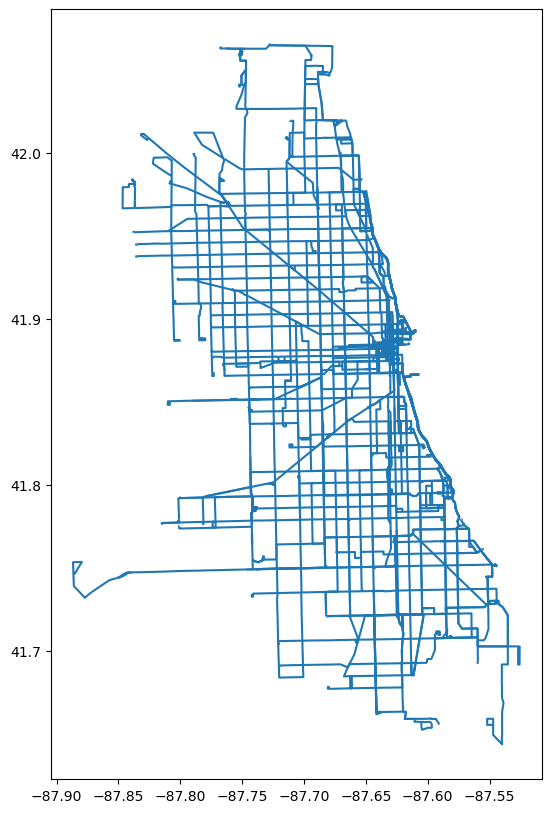

In [21]:
import pandas as pd
import geopandas as gpd
import ast
from shapely.geometry import shape, LineString, MultiLineString

# === 2. 解析 the_geom 为 shapely 几何对象 ===
def parse_multilinestring(g):
    try:
        geom_dict = ast.literal_eval(g)  # 安全解析字符串为字典
        geom = shape(geom_dict)          # 转为 shapely 几何对象
        return geom
    except Exception as e:
        print(f"解析失败: {e}")
        return None

cta_geo["geometry"] = cta_geo["the_geom"].apply(parse_multilinestring)

# === 3. 丢弃解析失败的记录 ===
cta_geo = cta_geo.dropna(subset=["geometry"])

# === 4. 构建 GeoDataFrame 并设置坐标系 ===
cta_geo_gdf = gpd.GeoDataFrame(cta_geo, geometry="geometry", crs="EPSG:4326")

# === 5. 可选：将 MultiLineString 分解为单段 LineString（用于空间交集分析） ===
cta_geo_gdf = cta_geo_gdf.explode(index_parts=False)

# === 6. 可选：可视化查看几何是否成功 ===
cta_geo_gdf.plot(figsize=(10, 10))

In [22]:
# 创建 GeoDataFrame
bus_routes_gdf = gpd.GeoDataFrame(cta_geo, geometry="geometry", crs="EPSG:4326")

# 如几何类型为 MultiLineString，建议 explode 成单段 LineString
bus_routes_gdf = bus_routes_gdf.explode(index_parts=False)

# 保留路线编号
bus_routes_gdf["route"] = bus_routes_gdf["route"].astype(str)

# === 读取 tract_gdf（如之前已准备好，可跳过）
tract_df = pd.read_csv("../../data/raw data/chicago_census_blocks_boundaries.csv")

# 解析 geometry
tract_df["geometry"] = tract_df["the_geom"].apply(loads)
tract_gdf = gpd.GeoDataFrame(tract_df, geometry="geometry", crs="EPSG:4326")

# === 叠加线路和 tract
route_with_tracts = gpd.overlay(bus_routes_gdf, tract_gdf, how="intersection")
route_with_tracts["segment_length"] = route_with_tracts.geometry.length
route_with_tracts["route"] = route_with_tracts["route"].astype(str)

# 标准化为比例
length_sum = route_with_tracts.groupby("route")["segment_length"].transform("sum")
route_with_tracts["segment_ratio"] = route_with_tracts["segment_length"] / length_sum

# === 合并每日客流数据
cta["route"] = cta["route"].astype(str)
cta["date"] = pd.to_datetime(cta["date"])

# 合并线路+日期客流信息
merged = pd.merge(route_with_tracts, cta, left_on="route", right_on="route", how="inner")
merged["estimated_rides"] = merged["rides"] * merged["segment_ratio"]

# === 最终结果：每天每个census tract的公交客流估计
daily_bus_by_tract = (
    merged.groupby(["GEOID10", "date"])["estimated_rides"]
    .sum()
    .reset_index()
    .rename(columns={"date": "date", "estimated_rides": "daily_bus_rides"})
)


/var/folders/_x/43n5hx2d6hqf1v6v65qbln8c0000gn/T/ipykernel_65067/3030060041.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  route_with_tracts["segment_length"] = route_with_tracts.geometry.length


In [23]:
daily_bus_by_tract.to_csv(os.path.join(PROCESSED_DATA_DIR, "cleaned_cta_bus_data.csv"), index=False)